In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Carga datos

In [2]:
df = pd.read_csv("../../data/processed/nasa/nasa_power_processed.csv", index_col=False)
df

,coord_hash,t2m_mean,t2m_p95,t2m_p99,t2m_range,rh2m_mean,rh2m_p95,rh2m_p99,rad_mean,rad_p95,...,prec_days_gt_18,prec_days_gt_31,dry_spell_max,ws_p95,ws_p99,ws_days_gt_4,ws_days_gt_6,evland_mean,evland_p95,evland_p99
0,0185cdf9e600,13.418689,14.910,15.6300,6.03,87.438344,92.400,93.7196,16.388739,22.172,...,209,35,54,2.250,2.5848,0,0,3.223436,4.510000,4.924800
1,021f18273d88,28.078073,29.374,29.8800,5.01,80.682836,86.128,87.5900,19.612371,25.340,...,93,35,31,7.894,9.0048,2930,1521,3.139086,3.906506,4.017322
2,071317421089,13.809201,15.214,15.9244,5.86,86.648470,91.100,92.7496,16.798454,21.814,...,236,56,42,1.770,2.1248,0,0,3.283975,4.534000,4.874800
3,0a88d5087728,16.730871,18.130,19.1000,5.91,87.927377,93.828,95.2444,17.700042,23.170,...,202,48,15,0.590,0.6600,0,0,2.966458,4.560000,4.964800
4,0d582b03d53e,15.377638,16.820,17.6600,5.71,83.723463,90.634,92.1396,15.167462,19.000,...,96,13,39,2.930,3.7800,18,0,2.645587,3.750000,4.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,f109266adbd9,15.381829,16.670,17.3892,5.27,86.753860,92.298,94.1896,16.300891,21.292,...,163,25,16,1.070,1.3048,0,0,3.341812,4.644000,5.000000
80,f45a4eb79dd7,15.377638,16.820,17.6600,5.71,83.723463,90.634,92.1396,15.167462,19.000,...,96,13,39,2.930,3.7800,18,0,2.645587,3.750000,4.200000
81,f482b38c33e4,28.010331,29.330,29.8296,5.01,80.820627,87.410,89.1196,19.645645,24.418,...,157,55,88,6.104,6.7448,1837,222,2.436953,4.750000,5.584800
82,f564773235f7,16.730871,18.130,19.1000,5.91,87.927377,93.828,95.2444,17.700042,23.170,...,202,48,15,0.590,0.6600,0,0,2.966458,4.560000,4.964800


In [3]:
df.columns

Index(['coord_hash', 't2m_mean', 't2m_p95', 't2m_p99', 't2m_range',
       'rh2m_mean', 'rh2m_p95', 'rh2m_p99', 'rad_mean', 'rad_p95', 'rad_p99',
       'prec_mean', 'prec_p95', 'prec_p99', 'prec_days_gt_18',
       'prec_days_gt_31', 'dry_spell_max', 'ws_p95', 'ws_p99', 'ws_days_gt_4',
       'ws_days_gt_6', 'evland_mean', 'evland_p95', 'evland_p99'],
      dtype='str')

## Modelo PCA

In [4]:
# Todas las variables disponibles luego de depurar correlaciones

all_vars = [
    't2m_mean', 't2m_p95', 't2m_p99', 't2m_range',
    'rh2m_mean', 'rh2m_p95', 'rh2m_p99', 'rad_mean', 'rad_p95', 'rad_p99',
    'prec_mean', 'prec_p95', 'prec_p99', 'prec_days_gt_18',
    'prec_days_gt_31', 'dry_spell_max', 'ws_p95', 'ws_p99', 'ws_days_gt_4',
    'ws_days_gt_6', 'evland_mean', 'evland_p95', 'evland_p99'
]

In [ ]:
# Escalamiento de variables

X = df[all_vars].fillna(df[all_vars].median()).copy()
X_scaled = StandardScaler().fit_transform(X)

In [6]:
# Aplicar PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

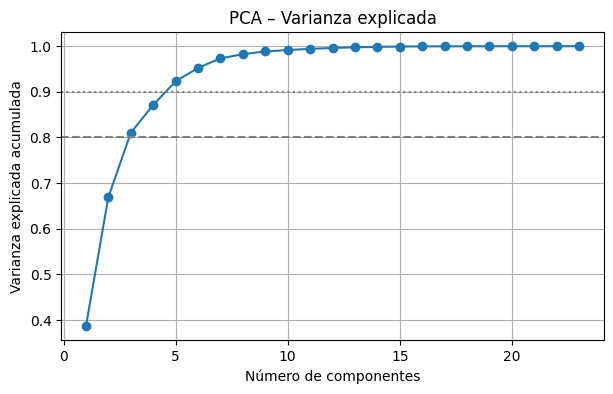

In [7]:
# Varianza explicada acumulada
# Gráfico para decidir número de componentes a retener

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.axhline(0.80, color='gray', linestyle='--')
plt.axhline(0.90, color='gray', linestyle=':')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA – Varianza explicada")
plt.grid(True)
plt.show()


In [8]:
# Cargar las cargas de los primeros 5 componentes principales
# Interpretar cuáles variables contribuyen más a cada componente
# Según la gráfica, más del 90% de la varianza se explica con 5 componentes

loadings = pd.DataFrame(
    pca.components_[:5].T,
    index=all_vars,
    columns=[f"PC{i+1}" for i in range(5)]
)

loadings

,PC1,PC2,PC3,PC4,PC5
t2m_mean,-0.284467,0.152066,0.062369,-0.014848,0.063959
t2m_p95,-0.279910,0.152983,0.095672,-0.013635,0.086449
t2m_p99,-0.274084,0.157688,0.122179,-0.011281,0.075783
t2m_range,-0.000994,0.049606,0.486376,0.045805,0.212877
rh2m_mean,0.236038,0.056689,-0.341077,0.160472,-0.141997
rh2m_p95,0.281590,0.061802,-0.156261,0.248291,-0.032889
rh2m_p99,0.284945,0.053497,-0.085008,0.300815,0.077616
rad_mean,-0.197662,0.224717,0.008772,0.412100,-0.174050
rad_p95,-0.136411,0.304009,0.005644,0.353756,-0.121567
rad_p99,-0.084002,0.322188,0.029221,0.314488,-0.109611


**PC1:** 
- Variables con mayor peso:

        * positivo: t2m_mean, t2m_p95, t2m_p99, rad_mean, dry_spell_max, ws_p95, ws_p99, ws_days_gt_4, ws_days_gt_6
        * negativo: rh2m_mean, rh2m_p95, rh2m_p99, prec_mean, evland_mean

- **(Calor + radiación + viento − humedad − precipitación)**
- Ambientes calientes, secos y ventosos. Capacidad de secado.
- Climas áridos 

**PC2:** 
- Variables con mayor peso:

        * positivo: rad_mean, rad_p95, rad_p99, prec_mean, prec_p95, prec_p99, prec_days_gt_18, prec_days_gt_31, evland_p95, evland_p99

- **(Radiación + precipitación + evaporación extrema)**
- Climas con alta rotación de agua
- Alta recepción de energía


**PC3:** 
- Variables con mayor peso:

        * positivo: t2m_range, evland_mean, evland_p95, evland_p99
        * negativo: rh2m_mean, prec_p99, ws_p95, ws_p99, ws_days_gt_4, ws_days_gt_6

- **(variabilidad térmica + evaporación − humedad − precipitación extrema − viento)**
- Alta oscilación térmica diaria/estacional
- Climas más estables térmicamente pero dinámicos en agua y viento

**PC4:** 
- Variables con mayor peso:

        * positivo: rh2m_p95, rh2m_p99, rad_mean, rad_p95, rad_p99, evland_mean, evland_p95, evland_p99
        * negativo: prec_p99, ws_p95, ws_p99, ws_days_gt_4, ws_days_gt_6

- **(Humedad alta + radiación + evaporación − precipitación extrema − viento)**
- Ambientes cálidos-húmedos y energéticos, pero poco ventosos
- Ambientes más turbulentos, con viento y lluvia extrema

**PC5:** 
- Variables con mayor peso:

        * positivo: t2m_range, prec_days_gt_18, prec_days_gt_31, dry_spell_max
        * negativo: rad_mean, ws_days_gt_4, ws_days_gt_6, evland_mean, evland_p95, evland_p99

- **(Variabilidad térmica + extremos de lluvia + sequías − radiación − viento − evaporación)**
- Eje de intermitencia climática y extremos combinados

In [15]:
df_pca_clima = pd.DataFrame(
    X_pca [:, :5],
    columns=[f"PC{i+1}_clima" for i in range(1, 6)],
    index=df.index
)

df_pca_clima

,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima
0,1.896154,-0.167227,-1.227641,0.361921,0.159969
1,-8.494893,0.655798,-3.788559,0.097171,-4.170502
2,1.990665,0.385417,-1.450250,-0.372119,0.559690
3,2.017086,1.020542,-1.056730,1.547760,0.015596
4,0.300663,-4.646489,-1.138519,-0.438717,0.644452
...,...,...,...,...,...
79,2.082934,-0.980566,-0.579778,0.301411,-0.659290
80,0.300663,-4.646489,-1.138519,-0.438717,0.644452
81,-5.999517,2.550090,-1.609409,0.055751,0.244521
82,2.017086,1.020542,-1.056730,1.547760,0.015596


In [16]:
# Combinar los scores PCA con el DataFrame original
df_clima_pc = pd.concat([df, df_pca_clima], axis=1)
df_clima_pc

,coord_hash,t2m_mean,t2m_p95,t2m_p99,t2m_range,rh2m_mean,rh2m_p95,rh2m_p99,rad_mean,rad_p95,...,ws_days_gt_4,ws_days_gt_6,evland_mean,evland_p95,evland_p99,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima
0,0185cdf9e600,13.418689,14.910,15.6300,6.03,87.438344,92.400,93.7196,16.388739,22.172,...,0,0,3.223436,4.510000,4.924800,1.896154,-0.167227,-1.227641,0.361921,0.159969
1,021f18273d88,28.078073,29.374,29.8800,5.01,80.682836,86.128,87.5900,19.612371,25.340,...,2930,1521,3.139086,3.906506,4.017322,-8.494893,0.655798,-3.788559,0.097171,-4.170502
2,071317421089,13.809201,15.214,15.9244,5.86,86.648470,91.100,92.7496,16.798454,21.814,...,0,0,3.283975,4.534000,4.874800,1.990665,0.385417,-1.450250,-0.372119,0.559690
3,0a88d5087728,16.730871,18.130,19.1000,5.91,87.927377,93.828,95.2444,17.700042,23.170,...,0,0,2.966458,4.560000,4.964800,2.017086,1.020542,-1.056730,1.547760,0.015596
4,0d582b03d53e,15.377638,16.820,17.6600,5.71,83.723463,90.634,92.1396,15.167462,19.000,...,18,0,2.645587,3.750000,4.200000,0.300663,-4.646489,-1.138519,-0.438717,0.644452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,f109266adbd9,15.381829,16.670,17.3892,5.27,86.753860,92.298,94.1896,16.300891,21.292,...,0,0,3.341812,4.644000,5.000000,2.082934,-0.980566,-0.579778,0.301411,-0.659290
80,f45a4eb79dd7,15.377638,16.820,17.6600,5.71,83.723463,90.634,92.1396,15.167462,19.000,...,18,0,2.645587,3.750000,4.200000,0.300663,-4.646489,-1.138519,-0.438717,0.644452
81,f482b38c33e4,28.010331,29.330,29.8296,5.01,80.820627,87.410,89.1196,19.645645,24.418,...,1837,222,2.436953,4.750000,5.584800,-5.999517,2.550090,-1.609409,0.055751,0.244521
82,f564773235f7,16.730871,18.130,19.1000,5.91,87.927377,93.828,95.2444,17.700042,23.170,...,0,0,2.966458,4.560000,4.964800,2.017086,1.020542,-1.056730,1.547760,0.015596


In [17]:
df_clima_pc.to_csv("../../data/processed/nasa/nasa_processed_pc.csv", index=False)

## Modelo de Clustering 

In [21]:
df.columns

Index(['coord_hash', 't2m_mean', 't2m_p95', 't2m_p99', 't2m_range',
       'rh2m_mean', 'rh2m_p95', 'rh2m_p99', 'rad_mean', 'rad_p95', 'rad_p99',
       'prec_mean', 'prec_p95', 'prec_p99', 'prec_days_gt_18',
       'prec_days_gt_31', 'dry_spell_max', 'ws_p95', 'ws_p99', 'ws_days_gt_4',
       'ws_days_gt_6', 'evland_mean', 'evland_p95', 'evland_p99'],
      dtype='str')

In [22]:
# Variables para modelo
# Variables para modelo (con extremos)
vars = [
    't2m_mean',
    't2m_range',
    'rh2m_mean',
    'rad_mean',
    'prec_mean',
    'prec_days_gt_31',
    'ws_days_gt_6',
    'evland_mean',
    'dry_spell_max'
]


X = df[vars]

In [23]:
# Estandarización de las variables
# Para que todas las variables tengan media 0 y desviación estándar 1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
from sklearn.metrics import silhouette_score

scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    scores[k] = silhouette_score(X_scaled, labels)

scores


{2: 0.4921344728975617,
 3: 0.38699515199344825,
 4: 0.48019498159751484,
 5: 0.5130685619029773,
 6: 0.5449441766431276}

In [25]:
# Selección del número de clusters
# Valor inicial con base en el puntaje de silhouette
# k=2 se toma como valor inicial, zonas con diferencias extramas climáticas

k = 2

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Guardar el perfil de los clusters en un archivo Excel
cluster_profile.to_excel("../../data/processed/nasa/reports/cluster_profile_" + str(k) + ".xlsx")

## Grafica

In [26]:
# Mapa de clusters iniciales de INSQUI
coord_index = pd.read_csv("../../data/raw/nasa/coord_index.csv")

In [27]:
# Extracción de coordenadas únicas
coords = (
    coord_index[["coord_hash", "lat_r", "lon_r"]]
    .drop_duplicates("coord_hash")
    .rename(columns={"lat_r": "latitud", "lon_r": "longitud"})
)

# Merge de coordenadas con el DataFrame principal
df_map = df.merge(coords, on="coord_hash", how="left")

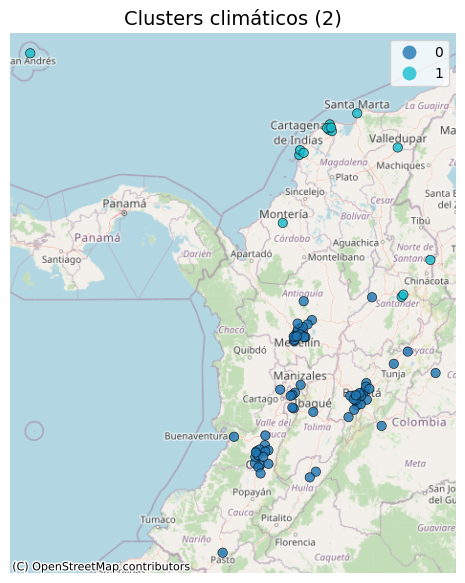

In [28]:
# Visualización de los clusters en el mapa
df_map["cluster"] = df["cluster"].values

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.9
)

# Ajustar extensión con padding
xmin, ymin, xmax, ymax = gdf.total_bounds
pad = 0.05 * (xmax - xmin)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title(
    "Clusters climáticos (" + str(k) + ")",
    fontsize=14
)

ax.set_axis_off()
plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
plt.show()


In [29]:
# Perfil detallado de los clusters
perfil = (
    df
    .groupby("cluster")[vars]
    .agg(["mean"])
)

perfil

,t2m_mean,t2m_range,rh2m_mean,rad_mean,prec_mean,prec_days_gt_31,ws_days_gt_6,evland_mean,dry_spell_max
,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,
0,17.567958,6.404928,84.743091,16.498083,5.027205,36.681159,0.014493,3.294263,22.405797
1,26.642733,6.430000,77.908041,19.075099,3.503176,40.866667,325.666667,2.425269,91.600000


## Análisis de clusters

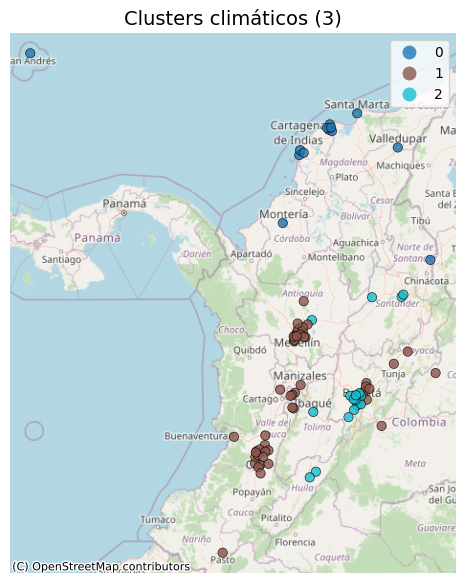

,t2m_mean,t2m_range,rh2m_mean,rad_mean,prec_mean,prec_days_gt_31,ws_days_gt_6,evland_mean,dry_spell_max
,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,
0,27.602011,6.039231,78.180389,19.192831,3.493000,42.692308,375.769231,2.338174,90.461538
1,16.667872,5.899038,86.533737,16.398627,5.125218,38.653846,0.019231,3.128209,23.153846
2,20.330242,8.059474,78.936555,16.960991,4.605498,30.473684,0.000000,3.716846,28.421053


In [30]:
# Selección del número de clusters
k = 3

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Guardar el perfil de los clusters en un archivo Excel
cluster_profile.to_excel("../../data/processed/nasa/reports/cluster_profile_" + str(k) + ".xlsx")

# Visualización de los clusters en el mapa
df_map["cluster"] = df["cluster"].values

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.9
)

# Ajustar extensión con padding
xmin, ymin, xmax, ymax = gdf.total_bounds
pad = 0.05 * (xmax - xmin)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title(
    "Clusters climáticos (" + str(k) + ")",
    fontsize=14
)

ax.set_axis_off()
plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
plt.show()

# Perfil detallado de los clusters
perfil = (
    df
    .groupby("cluster")[vars]
    .agg(["mean"])
)

perfil


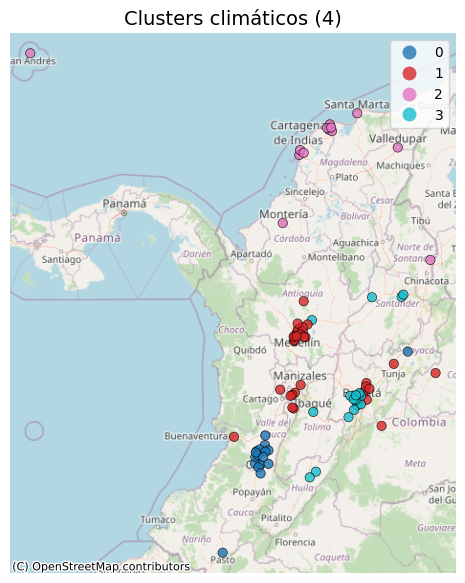

,t2m_mean,t2m_range,rh2m_mean,rad_mean,prec_mean,prec_days_gt_31,ws_days_gt_6,evland_mean,dry_spell_max
,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,
0,16.062951,5.598824,84.748327,15.214063,3.609964,11.470588,0.058824,2.809845,27.058824
1,16.961691,6.044857,87.400936,16.973986,5.861198,51.857143,0.000000,3.282843,21.257143
2,27.602011,6.039231,78.180389,19.192831,3.493000,42.692308,375.769231,2.338174,90.461538
3,20.330242,8.059474,78.936555,16.960991,4.605498,30.473684,0.000000,3.716846,28.421053


In [31]:
# Selección del número de clusters
k = 4

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Guardar el perfil de los clusters en un archivo Excel
cluster_profile.to_excel("../../data/processed/nasa/reports/cluster_profile_" + str(k) + ".xlsx")

# Visualización de los clusters en el mapa
df_map["cluster"] = df["cluster"].values

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.9
)

# Ajustar extensión con padding
xmin, ymin, xmax, ymax = gdf.total_bounds
pad = 0.05 * (xmax - xmin)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title(
    "Clusters climáticos (" + str(k) + ")",
    fontsize=14
)

ax.set_axis_off()
plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
plt.show()

# Perfil detallado de los clusters
perfil = (
    df
    .groupby("cluster")[vars]
    .agg(["mean"])
)

perfil


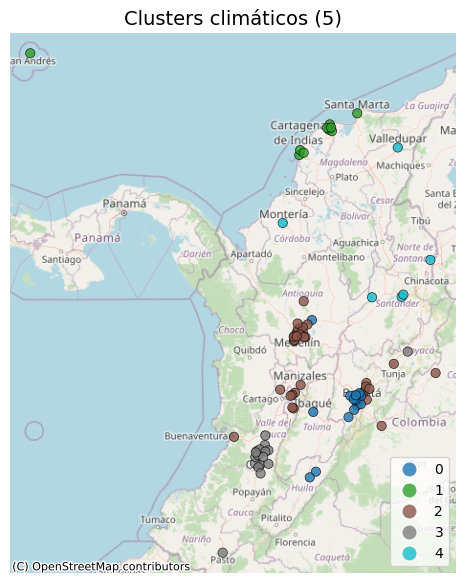

,t2m_mean,t2m_range,rh2m_mean,rad_mean,prec_mean,prec_days_gt_31,ws_days_gt_6,evland_mean,dry_spell_max
,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,
0,19.970716,7.744375,79.030354,16.708081,4.712274,27.625000,0.000000,3.811006,17.937500
1,28.094481,5.160000,79.964854,19.694770,3.794478,48.000000,488.500000,2.396192,82.200000
2,16.961691,6.044857,87.400936,16.973986,5.861198,51.857143,0.000000,3.282843,21.257143
3,16.062951,5.598824,84.748327,15.214063,3.609964,11.470588,0.058824,2.809845,27.058824
4,24.104081,9.355000,75.334233,17.914771,3.262050,35.333333,0.000000,2.679720,101.166667


In [32]:
# Selección del número de clusters
k = 5

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Guardar el perfil de los clusters en un archivo Excel
cluster_profile.to_excel("../../data/processed/nasa/reports/cluster_profile_" + str(k) + ".xlsx")

# Visualización de los clusters en el mapa
df_map["cluster"] = df["cluster"].values

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.9
)

# Ajustar extensión con padding
xmin, ymin, xmax, ymax = gdf.total_bounds
pad = 0.05 * (xmax - xmin)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title(
    "Clusters climáticos (" + str(k) + ")",
    fontsize=14
)

ax.set_axis_off()
plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
plt.show()

# Perfil detallado de los clusters
perfil = (
    df
    .groupby("cluster")[vars]
    .agg(["mean"])
)

perfil


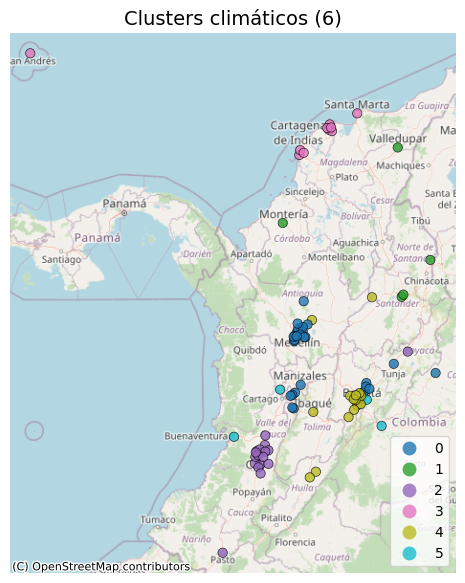

,t2m_mean,t2m_range,rh2m_mean,rad_mean,prec_mean,prec_days_gt_31,ws_days_gt_6,evland_mean,dry_spell_max
,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,
0,16.551437,6.093871,87.258091,17.152989,5.627729,42.483871,0.000000,3.244928,21.967742
1,23.739238,8.970000,73.794415,17.835757,2.920573,26.600000,0.000000,2.483423,110.400000
2,16.062951,5.598824,84.748327,15.214063,3.609964,11.470588,0.058824,2.809845,27.058824
3,28.094481,5.160000,79.964854,19.694770,3.794478,48.000000,488.500000,2.396192,82.200000
4,20.321161,7.952353,79.265823,16.802303,4.727401,30.647059,0.000000,3.802194,20.117647
5,20.141163,5.665000,88.507984,15.586709,7.670587,124.500000,0.000000,3.576681,15.750000


In [33]:
# Selección del número de clusters
k = 6

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Guardar el perfil de los clusters en un archivo Excel
cluster_profile.to_excel("../../data/processed/nasa/reports/cluster_profile_" + str(k) + ".xlsx")

# Visualización de los clusters en el mapa
df_map["cluster"] = df["cluster"].values

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.9
)

# Ajustar extensión con padding
xmin, ymin, xmax, ymax = gdf.total_bounds
pad = 0.05 * (xmax - xmin)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title(
    "Clusters climáticos (" + str(k) + ")",
    fontsize=14
)

ax.set_axis_off()
plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
plt.show()

# Perfil detallado de los clusters
perfil = (
    df
    .groupby("cluster")[vars]
    .agg(["mean"])
)

perfil


## Extracción data

In [34]:
# Selección del número de clusters
k = 4

# Aplicación de KMeans con el número seleccionado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Perfil de los clusters (promedios)
cluster_profile = df.groupby("cluster")[vars].mean()

# Número de puntos en cada cluster
cluster_profile["n_puntos"] = df["cluster"].value_counts().sort_index()

# Selección de columnas finales para guardar
cols_finales = [
    "coord_hash",
    "latitud",
    "longitud",
    "cluster",
    't2m_mean',
    't2m_range',
    'rh2m_mean',
    'rad_mean',
    'prec_mean',
    'prec_days_gt_31',
    'ws_days_gt_6',
    'evland_mean',
    'dry_spell_max'
]

# Unión de coordenadas con el DataFrame principal
df = df.merge(coords, on="coord_hash", how="left")

# Guardar el DataFrame final con clusters
df_final = df[cols_finales].copy()
df_final.to_csv("../../data/processed/nasa/cluster_clima_k4.csv", index=False)
